In [10]:
!pip install ultralytics
!pip install clearml

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 1.1 MB/s eta 0:00:0000:0100:010m


# Генерим датасет

In [12]:
!unzip dataset.zip
!mkdir -p train
!mkdir -p val

In [13]:
import glob
import os

for file in glob.glob("*.jpg"):
    os.rename(file, os.path.join('train', file))

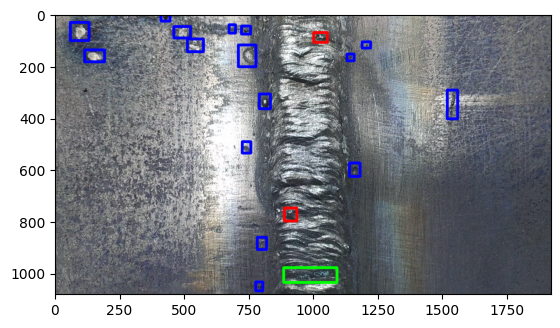

In [2]:
import cv2
import matplotlib.pyplot as plt

BLUE = (0, 0, 255)
RED = (255, 0, 0)
GREEN = (0, 255, 0)
PINK = (255, 20, 147)
VIOLET = (75, 0, 130)

name = 'dataset/1 (1)'

img = cv2.imread(name + '.jpg')
#print(img)
dh, dw, _ = img.shape

for dt in open(name+'.txt', 'r').readlines():

    # Split string to float
    type_defect, x, y, w, h = map(float, dt.split(' '))

    # Taken from https://github.com/pjreddie/darknet/blob/810d7f797bdb2f021dbe65d2524c2ff6b8ab5c8b/src/image.c#L283-L291
    # via https://stackoverflow.com/questions/44544471/how-to-get-the-coordinates-of-the-bounding-box-in-yolo-object-detection#comment102178409_44592380
    l = int((x - w / 2) * dw)
    r = int((x + w / 2) * dw)
    t = int((y - h / 2) * dh)
    b = int((y + h / 2) * dh)
    
    if l < 0:
        l = 0
    if r > dw - 1:
        r = dw - 1
    if t < 0:
        t = 0
    if b > dh - 1:
        b = dh - 1

    if type_defect == 0:        
        cv2.rectangle(img, (l, t), (r, b), BLUE, 10)
    elif type_defect == 1:
        cv2.rectangle(img, (l, t), (r, b), RED, 10)
    elif type_defect==2:
        cv2.rectangle(img, (l, t), (r, b), GREEN, 10)
    elif type_defect==3:
        cv2.rectangle(img, (l, t), (r, b), GREEN, 10)
    elif type_defect==4:
        cv2.rectangle(img, (l, t), (r, b), WHITE, 10)
   
plt.imshow(img)
plt.show()

# Тренировка

In [8]:
from ultralytics import YOLO

model = YOLO('yolov8n.pt')
result = model.predict(
   source=name+'.jpg',
   conf=0.25
)


image 1/1 /home/adil/Projects/atomic_hack/dataset/1 (1).jpg: 384x640 (no detections), 204.1ms
Speed: 7.0ms preprocess, 204.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


In [9]:
result.show()

AttributeError: 'list' object has no attribute 'show'

# Генерация результата

In [1]:
path_to_images = 'dataset/train'

In [20]:
import glob
import os
from tqdm import tqdm

def line_to_row(line):
    line = line.split()
    return [int(line[0]), float(line[1]), float(line[2]), float(line[3])+0.01, float(line[4])+0.01]

lst = []
for file in tqdm(glob.glob(os.path.join(path_to_images, "*.txt"))):
    name = os.path.basename(file)[:-4]
    with open(file, 'r') as f:
        for line in f.readlines():
            lst.append([name]+line_to_row(line))
lst[:10]

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1162/1162 [00:00<00:00, 5130.94it/s]


[['11 (14)', 2, 0.508858, 0.055229, 0.266567, 0.096957],
 ['12 (1)', 1, 0.684789, 0.640423, 0.050318, 0.10400699999999999],
 ['5 (89)', 2, 0.491448, 0.249706, 0.125455, 0.16628700000000002],
 ['6 (39)', 2, 0.565058, 0.736193, 0.220141, 0.105182],
 ['6 (39)', 3, 0.327428, 0.596357, 0.149279, 0.07933],
 ['6 (10)', 2, 0.43708, 0.092832, 0.157221, 0.129859],
 ['6 (10)', 2, 0.556811, 0.181551, 0.21953, 0.116933],
 ['1 (3)', 2, 0.485339, 0.442421, 0.070476, 0.058179],
 ['1 (3)', 2, 0.477703, 0.032315, 0.057648000000000005, 0.053478000000000005],
 ['1 (3)', 0, 0.605681, 0.120447, 0.035046, 0.243843]]

In [21]:
import pandas as pd

df = pd.DataFrame(lst, columns=['filename', 'class_id', 'rel_x', 'rel_y', 'width', 'height'])
df

,filename,class_id,rel_x,rel_y,width,height
0,11 (14),2,0.508858,0.055229,0.266567,0.096957
1,12 (1),1,0.684789,0.640423,0.050318,0.104007
2,5 (89),2,0.491448,0.249706,0.125455,0.166287
3,6 (39),2,0.565058,0.736193,0.220141,0.105182
4,6 (39),3,0.327428,0.596357,0.149279,0.079330
...,...,...,...,...,...,...
3420,5 (31),0,0.244044,0.113984,0.039933,0.181563
3421,5 (31),0,0.284973,0.094007,0.052150,0.188613
3422,5 (111),2,0.500305,0.795535,0.107740,0.106357
3423,5 (111),2,0.501527,0.458872,0.107740,0.189788


In [22]:
df.to_csv('submission.csv', index=False, sep=';')